In [2]:
from helper_functions import make_counts_df

In [1]:
import os
import numpy as np
import pandas as pd
import plotly_factory as plf
from plotly_factory import *
import plotly.graph_objs as go

import plotly as pl
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from collections import OrderedDict, defaultdict
from datetime import datetime
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats

import os
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from collections import OrderedDict
from plotly.io import write_html

df_serbia = pd.read_csv("data\df_serbia_englang.csv")
df_germany = pd.read_csv("data\df_germany_englang.csv").sample(n=len(df_serbia))
df = pd.concat([df_serbia, df_germany], sort=False)

In [ ]:
manufacturers_germany = plf.plot_horizontal_count_bars(
    df_germany, "manufacturer",
    first_n=12, show_percentage=False, text_position="auto",
    colorscale="mint",
)
manufacturers_germany.update_layout(
    title=plf.title_layout(
        "<b>German</b> market", title_size=20, color="#52527a"),
    yaxis=plf.axis_layout(
        "Car brand", showticklabels=False),
    xaxis=plf.axis_layout(
        "Number of Cars", tick_size=16, dtick=2000, range_=[0, 12000], show_exponent="last", show_grid=True),
)
manufacturers_germany.show(renderer="svg", width = 800, height=550)

In [5]:
models_per_manuf_serbia = make_counts_df(
    df_serbia, "manufacturer", "model", 6, 5, add_percentage=True, bold=True)
models_per_manuf_germany = make_counts_df(
    df_germany, "manufacturer", "model", 6, 5, add_percentage=True)

In [6]:
mod_per_manuf_serbia = plf.plot_table(
    models_per_manuf_serbia,
    cell_align="left", 
    header_align="center", 
    cell_height=48,
    transparent=True
)

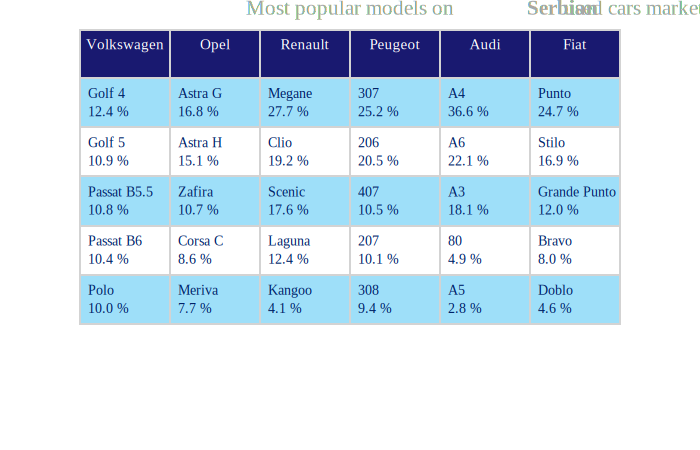

In [8]:
mod_per_manuf_serbia.layout.update(
    title=plf.title_layout(
        "Most popular models on <b>Serbian</b> used cars market", 
        y_position=1
        ),
    margin={"t":30, "b":0},
)
mod_per_manuf_serbia.show(renderer="svg")


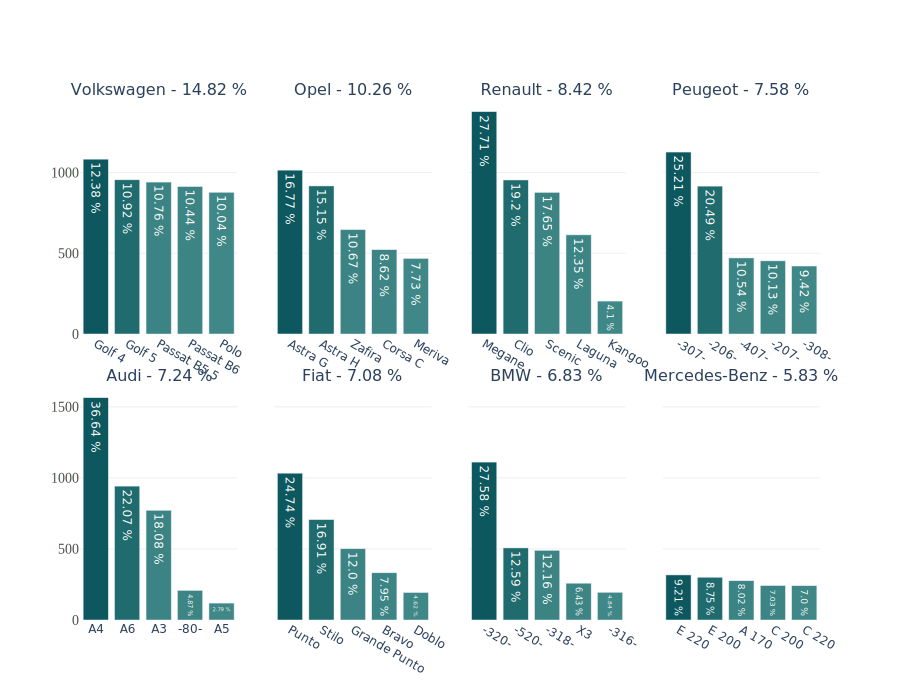

In [9]:
subplots = plf.plot_count_subplots(df_serbia, "manufacturer", "model", 2, 4, 5, show_main_percentages=True,  transparent=True, share_x=False)
subplots.show(renderer="svg", height = 700, width=900)

In [6]:
top_styles_count = df_serbia["body_style"].value_counts().index[:6]
top_fuel_types_count = df_serbia["fuel_type"].value_counts().index[:3]

fuel_distribution = plot_histograms(
    df_serbia, 
    "body_style", 
    top_styles_count,
    "fuel_type", 
    top_fuel_types_count, 
    y_legend=1,
    text_position="auto",
    percentage=True, 
    percentage_relative_to="main_category"
)
fuel_distribution.show(renderer="svg", height = 500, width=1000)

TypeError: plot_histograms() got an unexpected keyword argument 'text_position'

In [67]:
def plot_histograms(df, main_column, main_categories, sub_column=None, sub_categories=None, color_pallete = "default",
                    show_box=False, x_legend=0.80, y_legend=0.7, legend_font="default", percentage=False, 
                    points = False, notched=True, mean=True, percentage_relative_to="sub_category", text_position="auto",
                    sort_values="initial_sort", transparent=True):
    
    legend_font = {"x": x_legend, "y":y_legend}
    
    if legend_font == "default":
        legend_font.update(
           {
                "bgcolor":"rgba(0,0,0,0)",
                "font":dict(size=18, family="Times New Roman")
           }
        )
    
    if color_pallete=="default":
        color_pallete = ["#191970", "#64b5f6", "#ef6c00", "#ffd54f"]
    
    
    # a trick to generate bar charts only for main category
    if sub_column is None:
        df["trick_column"] = len(df)*["trick"]
        sub_categories = ["trick"]
        sub_column="trick_column"
        showlegend=False
        domain_1 =[0.90, 1]
        domain_2 =[0, 0.90]
    else:
        showlegend=True
        domain_1 =[0.80, 1]
        domain_2 =[0, 0.80]
    
    # iterate over all subcategories
    for k, sub in enumerate(sub_categories):
        # count entries of each subcategory that belongs to provided main category
        counts = df.loc[(df[main_column].isin(main_categories)) & (
            df[sub_column] == sub)][main_column].value_counts().sort_index()
        for main in main_categories:
            if main not in counts.index:
                counts.at[main] = 0
        x_ = counts.index

        ## percentage options ##
        if percentage:
            if percentage_relative_to == "sub_category":
                y_ = 100 * counts.values / len(df.loc[df[sub_column] == sub])
            elif percentage_relative_to == "total":
                y_ = 100 * counts.values / len(df)
            elif percentage_relative_to == "main_category":
                denominator = df.loc[df[main_column].isin(
                    main_categories)][main_column].value_counts().sort_index()
                for main in main_categories:
                    if main not in denominator.index:
                        denominator.at[main] = 0
                y_ = 100 * counts.values / denominator.values
        else:
            y_ = counts.values

        # sorting options
        if sort_values == "counts":
            x_y_ = list(zip(x_, y_))
            x_y_sorted = sorted(x_y_, key=lambda item: item[1], reverse=True)
            x_ = [item[0] for item in x_y_sorted]
            y_ = [item[1] for item in x_y_sorted]
        elif sort_values == "initial_sort":
            values_dict = OrderedDict(zip(x_, y_))
            y_ = np.array([values_dict.get(key) for key in main_categories])
            x_ = main_categories
        
        if percentage:
            text = [f"{y:.1f} %" for y in  y_]
        else:
            text = [f"{y:.0f}" for y in  y_]
            
            

        # for every subcategory make a bar chart
        bar = go.Bar(
            y=np.round(y_, 2),
            x=x_,
            marker=dict(color=color_pallete[k], opacity=0.7),
            name=sub,
            text=text,
            textposition=text_position,
            hoverinfo="x +  text",
            showlegend=showlegend
                    )

        if show_box:
            # if show_box is True, make a subplots 2x1
            if k == 0:
                fig = make_subplots(rows=2, cols=1)
            box = go.Box(
                x=df.loc[df[sub_column] == sub][main_column],
                marker=dict(color=colors[k]),
                boxpoints=points,
                notched=notched,
                boxmean=mean,
                showlegend=False,
            )
            
            # add box and bar plots to the subplots
            fig.add_trace(box, row=1, col=1)
            fig.add_trace(bar, row=2, col=1)

            fig.layout["xaxis"].update(
                axis_layout(
                    showticklabels=False,
                    range_=[main_categories[0], main_categories[-1]],
                )
            )

            # set box-bar ratio to 0.8 : 0.2
            fig.layout["yaxis"].update(
                axis_layout(showticklabels=False),
                                       domain=domain_1)

            fig.layout["yaxis2"].update(domain=domain_2)

        else:
            # if show_box is False, make a single Figure and add bar chart
            if k == 0:
                fig = go.Figure()
            fig.add_trace(bar)
    
    fig.update_layout(legend=legend_font)
    
    if transparent:
        fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    
    if "trick_column" in df.columns:
        df.drop(columns=["trick_column"], inplace=True)
        
    return fig

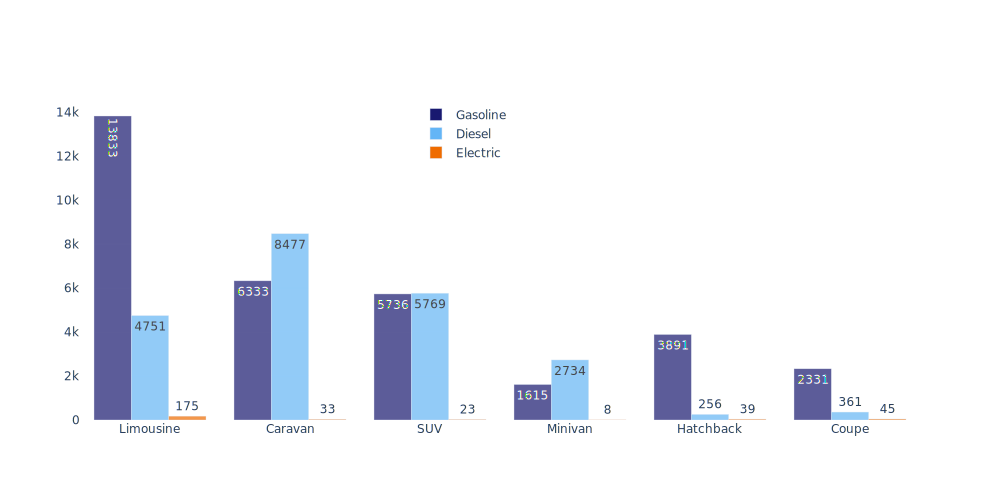

In [68]:
top_styles_count_ger = df_germany["body_style"].value_counts().index[:6]
top_fuel_types_count_ger = df_germany["fuel_type"].value_counts().index[:3]

fuel_distribution_ger = plot_histograms(
    df_germany, 
    "body_style", 
    top_styles_count_ger, 
    "fuel_type",  
    top_fuel_types_count_ger, 
    y_legend=1, 
    x_legend=0.4, 
    percentage=False, 
    percentage_relative_to="main_category",
    transparent=True
)

fuel_distribution_ger.show(renderer="svg", height = 500, width=1000)

In [51]:
df_germany.loc[df_germany["body_style"]=="Minivan"]["fuel_type"].value_counts(normalize=True)

Diesel              0.625772
Gasoline            0.369650
LPG (+ Gasoline)    0.002747
Electric            0.001831
Name: fuel_type, dtype: float64

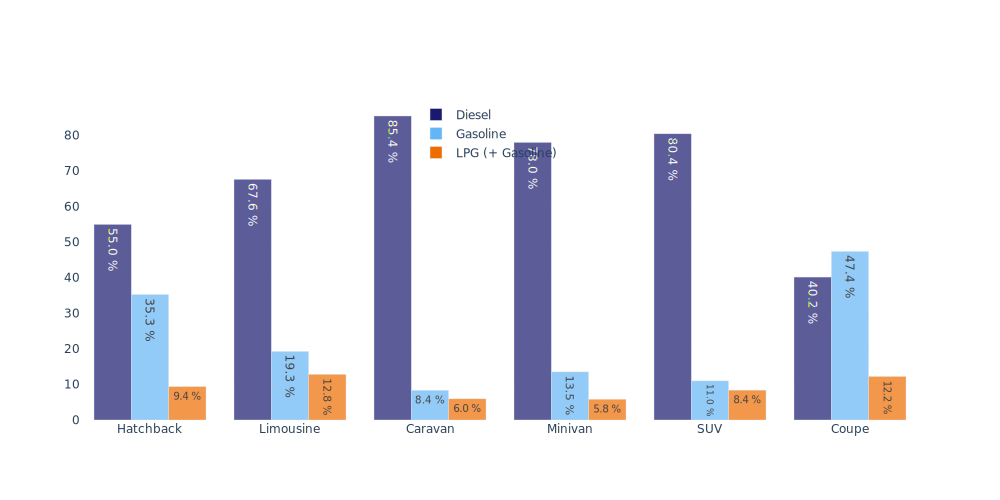

In [52]:
top_styles_count_serb = df_serbia["body_style"].value_counts().index[:6]
top_fuel_types_count_serb = df_serbia["fuel_type"].value_counts().index[:3]

fuel_distribution_ger = plot_histograms(
    df_serbia, 
    "body_style", 
    top_styles_count_serb, 
    "fuel_type",  
    top_fuel_types_count_serb, 
    y_legend=1, 
    x_legend=0.4, 
    percentage=True, 
    percentage_relative_to="main_category")

fuel_distribution_ger.show(renderer="svg", height = 500, width=1000)

In [53]:
top_fuel_types_count_serb

Index(['Diesel', 'Gasoline', 'LPG (+ Gasoline)'], dtype='object')